## Initialisation

In [ ]:
import numpy as np
from scipy.stats import poisson
from itertools import product
import itertools

In [ ]:
# Store the 2-dimensional state spaces
# Define the model in terms of transition probabilities
# Compute the values iteratively
# Run the policy improvement step

In [ ]:
Actions = np.empty((21,21),dtype=object)
Q_sa = np.empty((21,21),dtype=object)

In [ ]:
# Storing a list of available actions for each state pair; The maximum number of cars that can be transferred is those available

for i in range(21):
  for j in range(21):
    l1 = np.arange(min(20,j+min(i,5))-j+1)
    l2 = -np.arange(min(20,i+min(j,5))-i+1)
    actions = np.unique(np.concatenate((l1,l2),axis=0))
    # if i == 0 and j == 1:
    #   print(l1,l2)
    Actions[i][j] = actions

In [ ]:
# Initialise a random policy (number of cars to be moved in each state space combination) and values for all states
values = np.zeros((21,21))
pi = np.zeros((21,21))

In [ ]:
# Set the parameters of the poisson distribution for each location

loc_1_rqlam = 3
loc_2_rqlam = 4
loc_1_rtlam = 3
loc_2_rtlam = 2

In [ ]:
returns = np.arange(21)
gamma = 0.9

In [ ]:
# Create arrays of values for possible values of requests and returns for each pair of states
def requests_returns(state1,state2,action,returns):
  # Initialising demand values based on the number of requests that can be fulfilled
  act_req_1 = np.arange(0,max(state1-action,0)+1)
  act_req_2 = np.arange(0,max(state2+action,0)+1)
  req_ret = np.unique(list(product(act_req_1, act_req_2, returns, returns)),axis=0)
  #print(max(state2-action,0))
  return req_ret

## Rewards

In [ ]:
# For the original problem formulate the evaluation
# Update the values by following policy pi

def Q_update(values,Q_sa):
  returns = np.arange(21)
  for state_1 in range(21):
    for state_2 in range(21):
      # For each action, compute the value function
      act_reward = {}
      for action in Actions[state_1][state_2]:

        # Compute request return combinations at location 1 for each action
        req_ret = requests_returns(state_1,state_2,action,returns)

        # Compute reward for each s_prime reached at each location and for taking each action

        #print(state_1,state_2,action,req_ret.shape)

        #print(req_ret.shape)
        reward_1 = req_ret[:,0]*10
        reward_2 = req_ret[:,1]*10

        # Compute transition probabilities and rewards for both locations
        # using the formula probability(requests)*probability(returns) under the given action

        prob = poisson.pmf(req_ret[:,0],loc_1_rqlam)*poisson.pmf(req_ret[:,2],loc_1_rtlam)*poisson.pmf(req_ret[:,1],loc_2_rqlam)*poisson.pmf(req_ret[:,3],loc_2_rtlam)

        # Derive the next state s_prime for both locations using the formula
        # New state = Old_state - requests + returns - action

        s_prime = np.column_stack((np.minimum(np.subtract(np.add(np.subtract(state_1,req_ret[:,0]),req_ret[:,2]),action),20),
                                 np.minimum(np.subtract(np.add(np.subtract(state_2,req_ret[:,1]),req_ret[:,3]),action),20)))

        # Compute the expected reward using the Bellman Equation
        # Here since the initial values are 0, a vector of 0s has been used instead of the actual values

        # Total reward is a sum of the rewards obtained as follows
        # -$10 for every car request
        # $2 for every transfer over and above the one from location 1 to location 2
        # -$4 for every parking in excess of 10 cars, at each location

        Total_reward = np.sum(prob*(reward_1+reward_2+ (np.where(np.subtract(s_prime[:,0],10)>0,1,0)+np.where(np.subtract(s_prime[:,1],10)>0,1,0))*2
        +gamma*np.zeros(s_prime.shape[0])))
        - np.sum(np.abs(np.where(action>0,action-1,action))*2)

        # Create a vector to save the model (probability, reward and new state) values for potential combinations of requests and returns

        if action not in act_reward:
          act_reward[action] = np.column_stack((prob,reward_1+reward_2,s_prime[:,0],s_prime[:,1]))
      Q_sa[state_1][state_2] = act_reward
  return Q_sa

In [ ]:
Model_ = Q_update(values,Q_sa)

In [ ]:
## Create a function to update model values for policy evaluation

def compute_value(state_1,state_2,action,model,values,gamma):
  s_primes = model[state_1][state_2][action]
  value = np.sum(s_primes[:,0]*(s_primes[:,1]+gamma*values[s_primes[:,2].astype(int),s_primes[:,3].astype(int)]))-np.sum(np.abs(action)*2)
  return value

## Policy Iteration

In [ ]:
## Policy evaluation

# Compute value under policy pi

def policy_eval(pi,values):
  epsilon = 1e-12
  delta = np.ones((21,21))*1e+6

  old_v = values

  while np.any(delta)>epsilon:
    for state_1 in range(21):
      for state_2 in range(21):
        #print(pi[state_1][state_2])
        values[state_1][state_2] = compute_value(state_1,state_2,pi[state_1][state_2],Model_,values,gamma)

    delta = np.absolute(old_v - values)
  return values

In [ ]:
## Policy improvement

## Choose the maximum value generating action as per Bellman optimality equation

def policy_improvement(Actions,Model_,values,gamma=0.9):
  policy_stable = True

  for state_1 in range(21):
      for state_2 in range(21):
        old_action = pi[state_1][state_2]
        maxval = -1
        for action in Actions[state_1][state_2]:
          new_action_value = compute_value(state_1,state_2,action,Model_,values,gamma)
          #print("before",maxval)
          if new_action_value > maxval:
            maxval = new_action_value
            pi[state_1][state_2] = action
          #print("old",old_action,"update",pi[state_1][state_2])
        if old_action != pi[state_1][state_2]:
          policy_stable = False
  return pi,policy_stable

In [ ]:
values

In [ ]:
## Alternate between policy evaluation and improvement until convergence

iter = 0
while True:

  values = policy_eval(pi, values)
  policy, stable = policy_improvement(Actions,Model_,values)
  iter+=1
  if stable:
      break

In [ ]:
iter

25

In [ ]:
pi

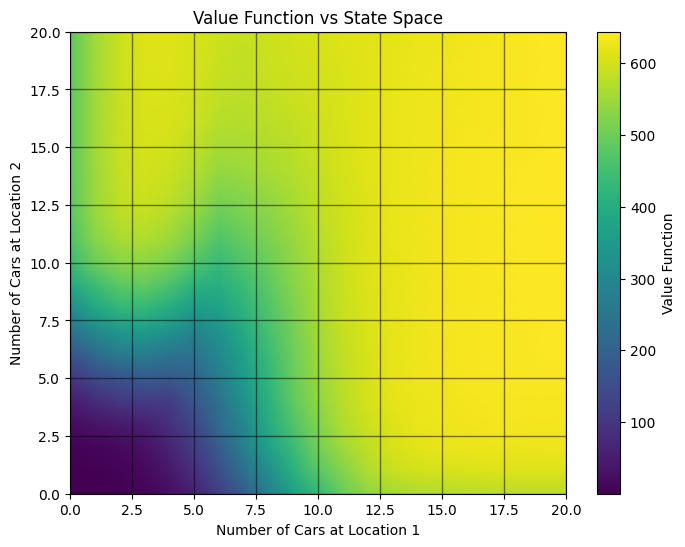

In [ ]:
import matplotlib.pyplot as plt

# Create a meshgrid for the state space
x = np.arange(0, 21)  # Adjust the range to include half steps for gridlines
y = np.arange(0, 21)
X, Y = np.meshgrid(x, y)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, values, cmap='viridis', shading='gouraud')
plt.colorbar(label='Value Function')
plt.xlabel('Number of Cars at Location 1')
plt.ylabel('Number of Cars at Location 2')
plt.title('Value Function vs State Space')

# Draw gridlines as boxes at intervals of 1
plt.grid(which='major', color='black', linewidth=1, linestyle='-', alpha=0.5)

plt.show()